## 1. Understanding the business

Purpose: to select the most popular video games available on the Steam platform
Stakeholder: the owner of the platform, who needs the results of research on the
popularity of specific video game genres

## 2. Data Working

**Features**


**Target Variable**
- `Rating`


### 2.1. Imports

In [189]:
# basic imports
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

# warnings
import warnings
warnings.filterwarnings('ignore')

# model selection

# feature eng and preprocessing

# hiperparams optimalization

# metrics

# models

### 2.2. Notebook Options

In [190]:
# Set table to show all columns
pd.set_option('display.max_columns', None)

# Seaborn Settings
sns.set_theme(style="darkgrid", palette="Dark2")

# Global Values
SEED = 80

### 2.3. Dataset Imports

In [191]:
# Read train dataset 
df = pd.read_csv('CSV\game_data_all.csv', index_col=0)

## 3. Data Check & Inspection

In [192]:
df.head()

,game,link,release,peak_players,positive_reviews,negative_reviews,total_reviews,rating,primary_genre,store_genres,publisher,developer,detected_technologies,store_asset_mod_time,review_percentage,players_right_now,24_hour_peak,all_time_peak,all_time_peak_date
0,Pizza Tower,/app/2231450/,2023-01-26,4529,19807,227,20034,96.39,Action (1),"Action (1), Indie (23)",Tour De Pizza,Tour De Pizza,Engine.GameMaker; SDK.FMOD,2023-01-10,98.0,"3,101","3,606",4529,2023-03-25
1,Resident Evil 4,/app/2050650/,2023-03-24,168191,61752,1616,63368,95.75,Action (1),"Action (1), Adventure (25)",CAPCOM Co. Ltd.,CAPCOM Co. Ltd.,Engine.RE_Engine; SDK.AMD_GPU_Services,2023-03-29,97.0,"46,289","47,164",168191,2023-03-25
2,The Murder of Sonic the Hedgehog,/app/2324650/,2023-03-31,15543,12643,213,12856,95.54,Casual (4),"Casual (4), Free to Play (37), Indie (23), Sim...",SEGA,SEGA,Engine.Unity; SDK.UnityBurst; SDK.cURL,2023-03-24,98.0,618,776,15543,2023-03-31
3,Pineapple on pizza,/app/2263010/,2023-03-28,1415,11717,209,11926,95.39,Indie (23),"Casual (4), Free to Play (37), Indie (23)",Majorariatto,Majorariatto,Engine.Unity; SDK.cURL,2023-03-22,98.0,101,101,1415,2023-03-28
4,Hi-Fi RUSH,/app/1817230/,2023-01-25,6132,14152,324,14476,95.09,Action (1),Action (1),Bethesda Softworks,Tango Gameworks,Engine.Unreal; SDK.Intel_OID; SDK.Intel_XeSS; ...,2023-04-11,97.0,630,664,6132,2023-01-29


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67571 entries, 0 to 67570
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   game                   67571 non-null  object 
 1   link                   67571 non-null  object 
 2   release                67571 non-null  object 
 3   peak_players           67571 non-null  int64  
 4   positive_reviews       67571 non-null  int64  
 5   negative_reviews       67571 non-null  int64  
 6   total_reviews          67571 non-null  int64  
 7   rating                 67571 non-null  float64
 8   primary_genre          67561 non-null  object 
 9   store_genres           67514 non-null  object 
 10  publisher              67110 non-null  object 
 11  developer              67443 non-null  object 
 12  detected_technologies  60265 non-null  object 
 13  store_asset_mod_time   67275 non-null  object 
 14  review_percentage      47767 non-null  float64
 15  players

In [194]:
df.describe()

,peak_players,positive_reviews,negative_reviews,total_reviews,rating,review_percentage,all_time_peak
count,6.757100e+04,6.757100e+04,67571.000000,6.757100e+04,67571.000000,47767.000000,6.757100e+04
mean,9.528674e+02,1.273527e+03,216.893801,1.490421e+03,65.288208,74.840497,9.629879e+02
std,1.979093e+04,2.955163e+04,5434.959528,3.400923e+04,14.059623,18.764257,2.017869e+04
min,0.000000e+00,0.000000e+00,0.000000,1.000000e+00,15.090000,0.000000,0.000000e+00
25%,3.000000e+00,5.000000e+00,1.000000,7.000000e+00,56.530000,64.000000,3.000000e+00
50%,7.000000e+00,1.900000e+01,6.000000,2.600000e+01,66.760000,79.000000,7.000000e+00
75%,4.600000e+01,9.900000e+01,29.000000,1.320000e+02,75.640000,90.000000,4.700000e+01
max,3.257248e+06,6.307931e+06,927317.000000,7.117776e+06,97.540000,100.000000,3.257248e+06


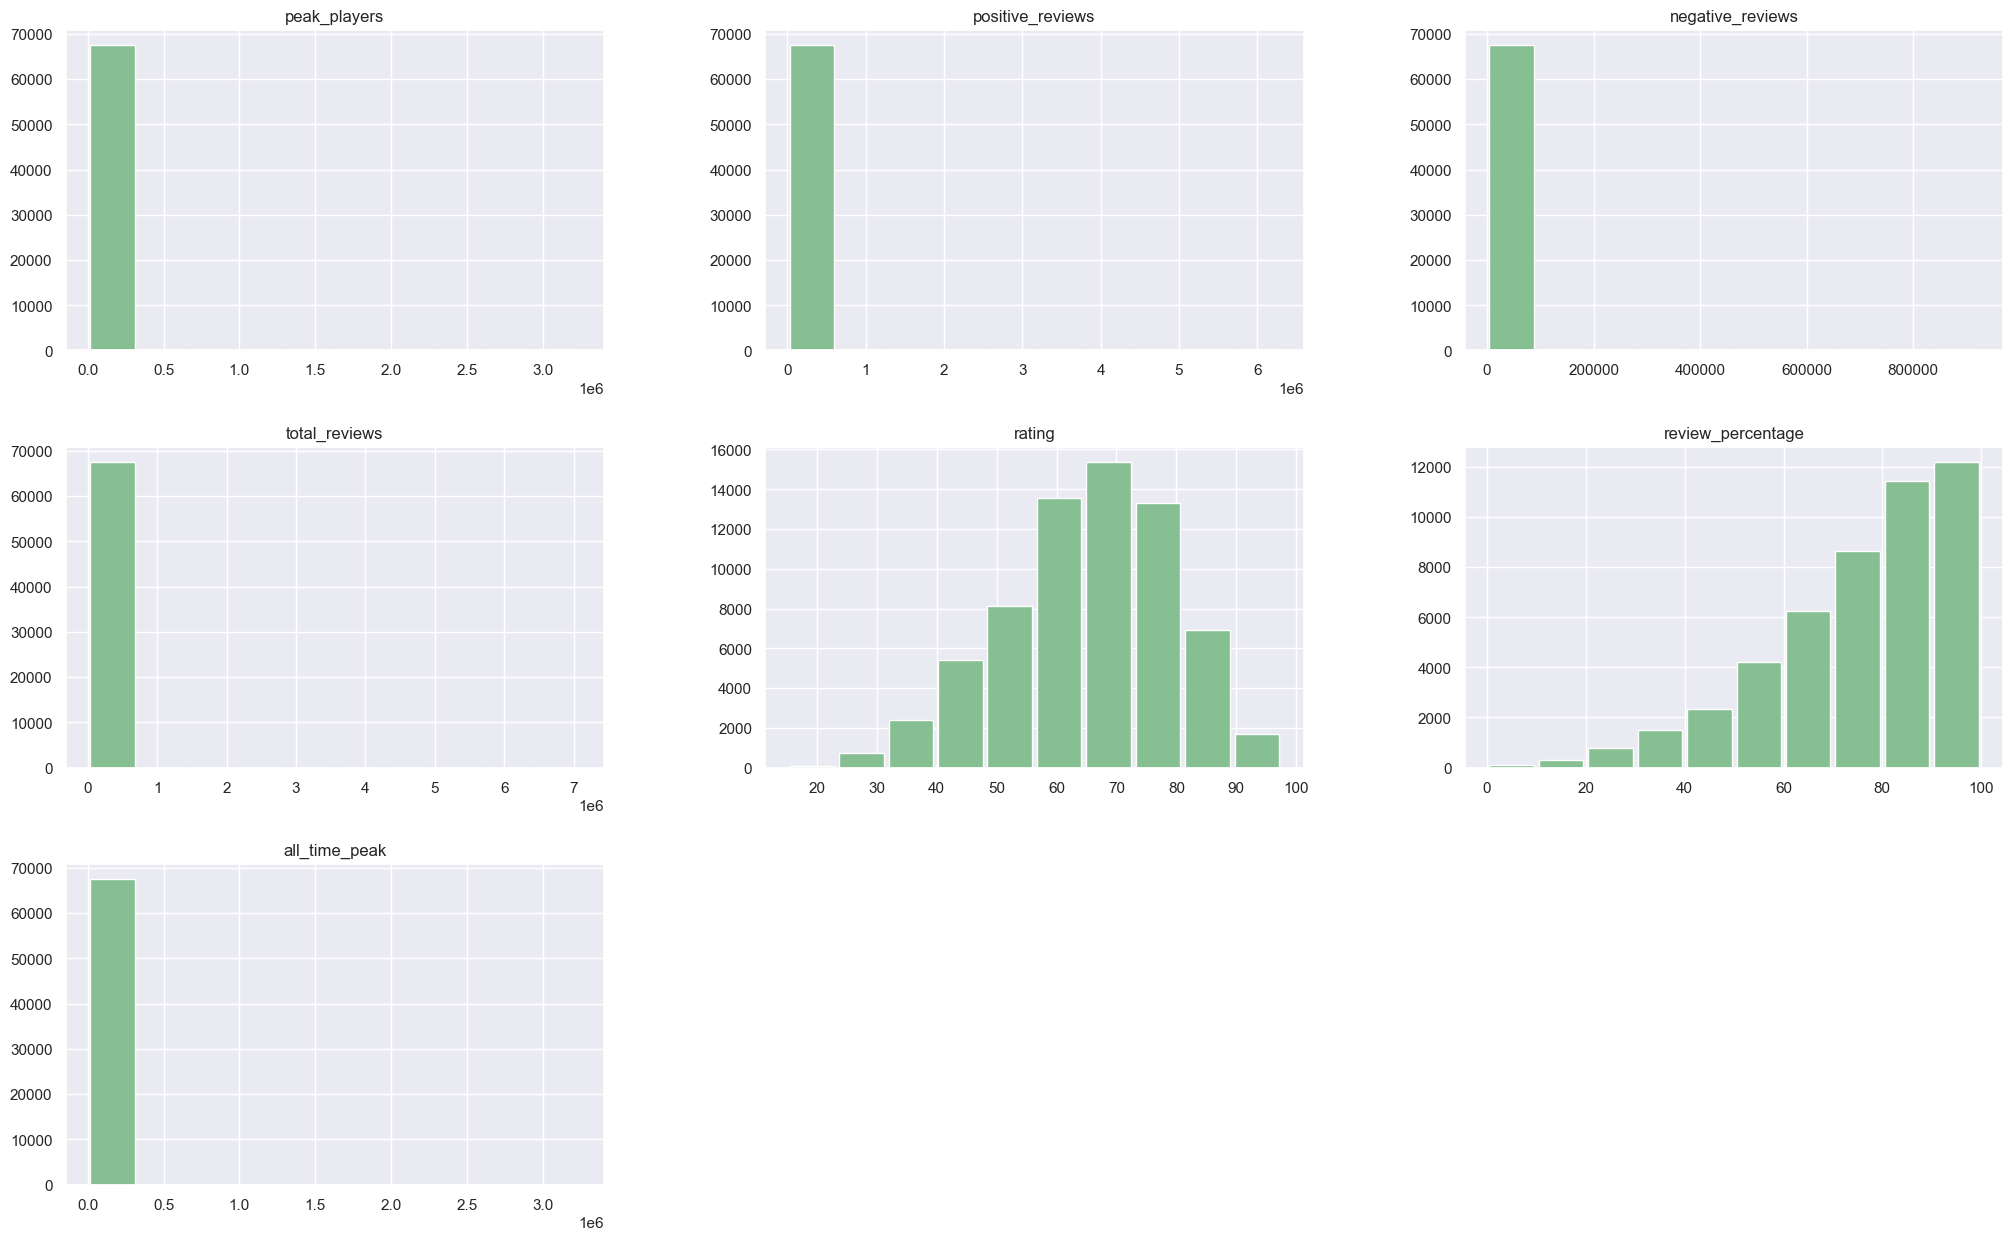

In [195]:
#Columns Distribution on Histograms
df.hist(figsize=(25,15), color='#86bf91', rwidth=0.9)
pass

In [196]:
df.isna().sum()

game                         0
link                         0
release                      0
peak_players                 0
positive_reviews             0
negative_reviews             0
total_reviews                0
rating                       0
primary_genre               10
store_genres                57
publisher                  461
developer                  128
detected_technologies     7306
store_asset_mod_time       296
review_percentage        19804
players_right_now            6
24_hour_peak                 6
all_time_peak                0
all_time_peak_date           6
dtype: int64

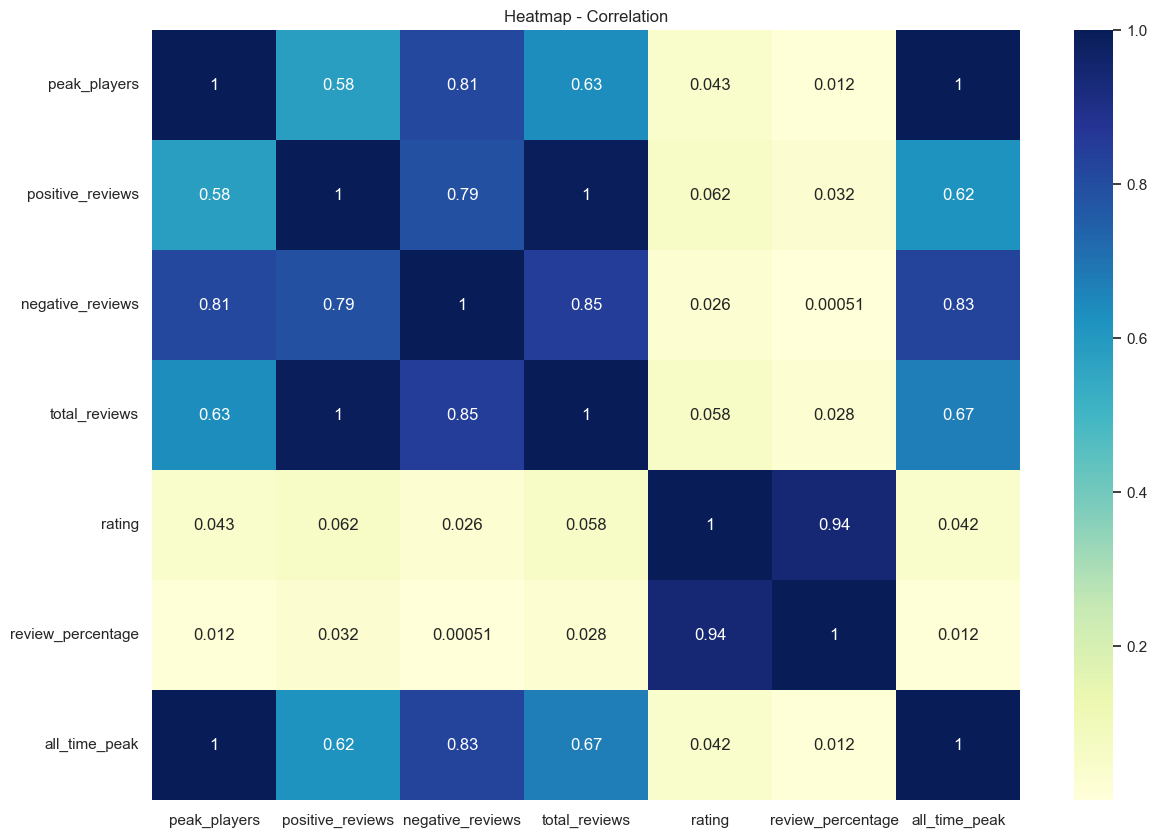

In [197]:
# Heatmap of correlation
plt.figure(figsize=(14, 10))
sns.heatmap(df.select_dtypes(include= 'number').corr(method= 'pearson'), cmap=  "YlGnBu", annot= True)
plt.title('Heatmap - Correlation')
plt.show()

## 4. Data Cleaning

In [198]:
df.head(10)

,game,link,release,peak_players,positive_reviews,negative_reviews,total_reviews,rating,primary_genre,store_genres,publisher,developer,detected_technologies,store_asset_mod_time,review_percentage,players_right_now,24_hour_peak,all_time_peak,all_time_peak_date
0,Pizza Tower,/app/2231450/,2023-01-26,4529,19807,227,20034,96.39,Action (1),"Action (1), Indie (23)",Tour De Pizza,Tour De Pizza,Engine.GameMaker; SDK.FMOD,2023-01-10,98.0,"3,101","3,606",4529,2023-03-25
1,Resident Evil 4,/app/2050650/,2023-03-24,168191,61752,1616,63368,95.75,Action (1),"Action (1), Adventure (25)",CAPCOM Co. Ltd.,CAPCOM Co. Ltd.,Engine.RE_Engine; SDK.AMD_GPU_Services,2023-03-29,97.0,"46,289","47,164",168191,2023-03-25
2,The Murder of Sonic the Hedgehog,/app/2324650/,2023-03-31,15543,12643,213,12856,95.54,Casual (4),"Casual (4), Free to Play (37), Indie (23), Sim...",SEGA,SEGA,Engine.Unity; SDK.UnityBurst; SDK.cURL,2023-03-24,98.0,618,776,15543,2023-03-31
3,Pineapple on pizza,/app/2263010/,2023-03-28,1415,11717,209,11926,95.39,Indie (23),"Casual (4), Free to Play (37), Indie (23)",Majorariatto,Majorariatto,Engine.Unity; SDK.cURL,2023-03-22,98.0,101,101,1415,2023-03-28
4,Hi-Fi RUSH,/app/1817230/,2023-01-25,6132,14152,324,14476,95.09,Action (1),Action (1),Bethesda Softworks,Tango Gameworks,Engine.Unreal; SDK.Intel_OID; SDK.Intel_XeSS; ...,2023-04-11,97.0,630,664,6132,2023-01-29
5,东北之夏,/app/2121360/,2023-01-09,8672,8891,165,9056,95.08,RPG (3),"Free to Play (37), RPG (3)",庄不纯工作室,庄不纯工作室,Engine.Unity,2022-09-29,98.0,62,75,8672,2023-01-10
6,Crab Champions,/app/774801/,2023-04-01,8564,5129,81,5210,94.76,Action (1),"Action (1), Adventure (25), Casual (4), Indie ...",Noisestorm Limited,Noisestorm Limited,Engine.Unreal; SDK.NVIDIA_APEX; SDK.NVIDIA_GeF...,2023-04-02,98.0,"4,142","6,419",8564,2023-04-08
7,Papa's Freezeria Deluxe,/app/2291760/,2023-03-31,1227,1832,20,1852,93.84,Strategy (2),"Action (1), Casual (4), Indie (23), Simulation...",Flipline Studios,Flipline Studios,Engine.Adobe_AIR,2023-03-28,99.0,661,838,1227,2023-04-02
8,A Space for the Unbound,/app/1201270/,2023-01-19,338,1917,27,1944,93.64,Adventure (25),"Adventure (25), Indie (23)",Toge Productions,Mojiken,Engine.Unity; SDK.FMOD; SDK.SteamworksNET; SDK...,2023-02-14,98.0,63,63,338,2023-01-20
9,Handshakes,/app/2171690/,2023-01-13,195,1166,10,1176,93.30,Free to Play (37),"Casual (4), Free to Play (37)",Pet Pumpkin,Pet Pumpkin,Engine.Unity; SDK.SteamworksNET; SDK.cURL,2023-03-26,99.0,8,15,195,2023-01-21


### 4.1. Missing Values

In [199]:
(df.isna().sum() / df.shape[0])*  100

game                      0.000000
link                      0.000000
release                   0.000000
peak_players              0.000000
positive_reviews          0.000000
negative_reviews          0.000000
total_reviews             0.000000
rating                    0.000000
primary_genre             0.014799
store_genres              0.084356
publisher                 0.682245
developer                 0.189430
detected_technologies    10.812331
store_asset_mod_time      0.438058
review_percentage        29.308431
players_right_now         0.008880
24_hour_peak              0.008880
all_time_peak             0.000000
all_time_peak_date        0.008880
dtype: float64

In [200]:
# Init function to drop column with missing values below 5%
def drop_nan(columns) :
    """ 
        Function that drop missing values for columns below 5% of dataset

        Args: 
            columns -> paramter of column name where we are checking and if below 5% drop missing values
        
    """
    for col in columns :
        nan = ((df[col].isna().sum() / df.shape[0])*  100)
        if nan > 0.0 and nan < 5.0: 
            df.dropna(subset= col, inplace= True)

In [201]:
drop_nan(df.columns.to_list())

In [202]:
(df.isna().sum() / df.shape[0])*  100

game                      0.000000
link                      0.000000
release                   0.000000
peak_players              0.000000
positive_reviews          0.000000
negative_reviews          0.000000
total_reviews             0.000000
rating                    0.000000
primary_genre             0.000000
store_genres              0.000000
publisher                 0.000000
developer                 0.000000
detected_technologies    10.756506
store_asset_mod_time      0.000000
review_percentage        29.481129
players_right_now         0.000000
24_hour_peak              0.000000
all_time_peak             0.000000
all_time_peak_date        0.000000
dtype: float64

In [203]:
# Check column review_percentage
df[df['review_percentage'].isna()]

,game,link,release,peak_players,positive_reviews,negative_reviews,total_reviews,rating,primary_genre,store_genres,publisher,developer,detected_technologies,store_asset_mod_time,review_percentage,players_right_now,24_hour_peak,all_time_peak,all_time_peak_date
178,Nebula,/app/2101250/,2023-01-25,67,82,3,85,84.31,Action (1),"Action (1), Indie (23), Early Access (70)",Szekretar,Szekretar,Engine.Unity,2016-05-14,NaN,0,0,3,2016-06-02
180,Nebula,/app/468130/,2016-06-02,3,4,0,4,69.20,Action (1),"Action (1), Indie (23), Early Access (70)",Szekretar,Szekretar,Engine.Unity,2016-05-14,NaN,0,0,3,2016-06-02
497,Hope,/app/2252550/,2023-01-27,3,18,0,18,79.39,Adventure (25),"Adventure (25), Casual (4), Indie (23)",Glusoft,Glusoft,NaN,2020-04-13,NaN,0,0,2,2021-08-03
499,Hope,/app/677590/,2020-08-07,2,3,2,5,54.17,Adventure (25),"Adventure (25), Casual (4), Indie (23)",Glusoft,Glusoft,NaN,2020-04-13,NaN,0,0,2,2021-08-03
920,Hentai Series,/app/1168190/,2023-02-11,3,9,0,9,75.00,Casual (4),"Adventure (25), Casual (4), Indie (23)",Pixel_Bebop,Pixel_Bebop,Engine.Unity; SDK.SteamworksNET; SDK.cURL,2023-01-18,NaN,0,1,3,2023-02-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66664,Mishap 2: An Intentional Haunting,/app/47570/,2011-01-28,6,2,0,2,64.08,Unknown Genre (33),Casual (4),Namco Networks America Inc.,Virtual Prophecy Entertainment,Engine.Torque; SDK.OpenAL; SDK.Vorbis,2011-01-28,NaN,0,0,6,2013-07-01
66896,Emergency 2012,/app/40370/,2010-11-22,38,6,2,8,62.10,Strategy (2),"Simulation (28), Strategy (2)",Deep Silver,Quadriga Games,Engine.Vision; SDK.NVIDIA_PhysX,2022-10-31,NaN,0,1,38,2012-07-01
66925,Vancouver 2010: The Official Video Game of the...,/app/34180/,2010-02-18,5,3,3,6,50.00,Sports (18),Sports (18),SEGA,Eurocom,SDK.Bink_Video,2020-01-21,NaN,0,0,5,2012-12-01
67223,Angle of Attack,/app/36900/,2009-08-17,2,0,3,3,32.94,Action (1),"Action (1), Casual (4), Indie (23), Simulation...",3000AD,3000AD,SDK.FMOD,2022-12-09,NaN,0,0,2,2014-06-27


In column review_percentage we have many missing values, in can mean that this specific game dosn't have any reviews by players so we can replace it with value = 0

In [204]:
# Fill NaN values for review_percentage with 0 
df['review_percentage'].fillna(0, inplace= True)

In [205]:
# Unique technologies
techs = df['detected_technologies'].unique().tolist()

In [206]:
# Function to replace NaN in detected_technologies column
def replace_with_random(replacement_list):
  """Fills NaN values in a column with a random value from a list.

  Args:
      replacement_list (list): The list of possible replacement values.
  """
  df['detected_technologies'].fillna(np.random.choice(replacement_list), inplace= True)

In [207]:
replace_with_random(techs)

In [208]:
(df.isna().sum() / df.shape[0])*  100

game                     0.0
link                     0.0
release                  0.0
peak_players             0.0
positive_reviews         0.0
negative_reviews         0.0
total_reviews            0.0
rating                   0.0
primary_genre            0.0
store_genres             0.0
publisher                0.0
developer                0.0
detected_technologies    0.0
store_asset_mod_time     0.0
review_percentage        0.0
players_right_now        0.0
24_hour_peak             0.0
all_time_peak            0.0
all_time_peak_date       0.0
dtype: float64

### 4.2. Change Feature Type

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66741 entries, 0 to 67569
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   game                   66741 non-null  object 
 1   link                   66741 non-null  object 
 2   release                66741 non-null  object 
 3   peak_players           66741 non-null  int64  
 4   positive_reviews       66741 non-null  int64  
 5   negative_reviews       66741 non-null  int64  
 6   total_reviews          66741 non-null  int64  
 7   rating                 66741 non-null  float64
 8   primary_genre          66741 non-null  object 
 9   store_genres           66741 non-null  object 
 10  publisher              66741 non-null  object 
 11  developer              66741 non-null  object 
 12  detected_technologies  66741 non-null  object 
 13  store_asset_mod_time   66741 non-null  object 
 14  review_percentage      66741 non-null  float64
 15  players

In [210]:
# Change to datetime
df['release'] = pd.to_datetime(df['release'])
df['all_time_peak_date'] = pd.to_datetime(df['all_time_peak_date'])

In [211]:
# Change to int
df['players_right_now'] = df['players_right_now'].str.replace(',', '').astype(int)

In [212]:
# Change to int
df['24_hour_peak'] = df['24_hour_peak'].str.replace(',', '').astype(int)

In [213]:
# Check if conversion was done correctly
assert df['release'].dtype in [np.dtype('<M8[ns]'), np.dtype('<M8[us]')], 'Column data type is not datetime64[ns] or datetime64[us]'

In [214]:
# Function that split string
def clean_genre(genre, splitter):
  """ 
    Clean string in genre

    Args: 
        genre -> string that will be converted
        splitter -> char to split string in column
    
    Return:
        corrected string 
  """
  try:
    return genre.split(splitter)[0]
  except AttributeError:
    return genre

In [215]:
# Use function clean_genre on primary_genre
df['primary_genre'] = df['primary_genre'].apply(clean_genre, args=(' (',))

In [216]:
# Use function clean_genre on store_genre
df['store_genres'] = df['store_genres'].apply(clean_genre, args=(' (',))

In [217]:
# Use function clean_genre on detected_technologies
df['detected_technologies'] = df['detected_technologies'].apply(clean_genre, args=(';',))

In [218]:
df.head(10)

,game,link,release,peak_players,positive_reviews,negative_reviews,total_reviews,rating,primary_genre,store_genres,publisher,developer,detected_technologies,store_asset_mod_time,review_percentage,players_right_now,24_hour_peak,all_time_peak,all_time_peak_date
0,Pizza Tower,/app/2231450/,2023-01-26,4529,19807,227,20034,96.39,Action,Action,Tour De Pizza,Tour De Pizza,Engine.GameMaker,2023-01-10,98.0,3101,3606,4529,2023-03-25
1,Resident Evil 4,/app/2050650/,2023-03-24,168191,61752,1616,63368,95.75,Action,Action,CAPCOM Co. Ltd.,CAPCOM Co. Ltd.,Engine.RE_Engine,2023-03-29,97.0,46289,47164,168191,2023-03-25
2,The Murder of Sonic the Hedgehog,/app/2324650/,2023-03-31,15543,12643,213,12856,95.54,Casual,Casual,SEGA,SEGA,Engine.Unity,2023-03-24,98.0,618,776,15543,2023-03-31
3,Pineapple on pizza,/app/2263010/,2023-03-28,1415,11717,209,11926,95.39,Indie,Casual,Majorariatto,Majorariatto,Engine.Unity,2023-03-22,98.0,101,101,1415,2023-03-28
4,Hi-Fi RUSH,/app/1817230/,2023-01-25,6132,14152,324,14476,95.09,Action,Action,Bethesda Softworks,Tango Gameworks,Engine.Unreal,2023-04-11,97.0,630,664,6132,2023-01-29
5,东北之夏,/app/2121360/,2023-01-09,8672,8891,165,9056,95.08,RPG,Free to Play,庄不纯工作室,庄不纯工作室,Engine.Unity,2022-09-29,98.0,62,75,8672,2023-01-10
6,Crab Champions,/app/774801/,2023-04-01,8564,5129,81,5210,94.76,Action,Action,Noisestorm Limited,Noisestorm Limited,Engine.Unreal,2023-04-02,98.0,4142,6419,8564,2023-04-08
7,Papa's Freezeria Deluxe,/app/2291760/,2023-03-31,1227,1832,20,1852,93.84,Strategy,Action,Flipline Studios,Flipline Studios,Engine.Adobe_AIR,2023-03-28,99.0,661,838,1227,2023-04-02
8,A Space for the Unbound,/app/1201270/,2023-01-19,338,1917,27,1944,93.64,Adventure,Adventure,Toge Productions,Mojiken,Engine.Unity,2023-02-14,98.0,63,63,338,2023-01-20
9,Handshakes,/app/2171690/,2023-01-13,195,1166,10,1176,93.30,Free to Play,Casual,Pet Pumpkin,Pet Pumpkin,Engine.Unity,2023-03-26,99.0,8,15,195,2023-01-21


### 4.3. Columns Drop

In [219]:
# Drop not needed columns
col_to_drop = ['link', 'store_asset_mod_time']
df.drop(columns=col_to_drop, inplace= True)

### 4.4. Outliners

In [220]:
def outliners(dataframe) :
    """
    Identifies and visualizes potential outliers in a DataFrame using boxplots.

    Args:
        dataframe (pandas.DataFrame): The DataFrame to analyze.

    Returns:
        None
    """
    num_col = dataframe.select_dtypes(include = 'number').columns.to_list()
    for col in num_col :
        sns.boxplot(data= df, x= col)
        plt.show()

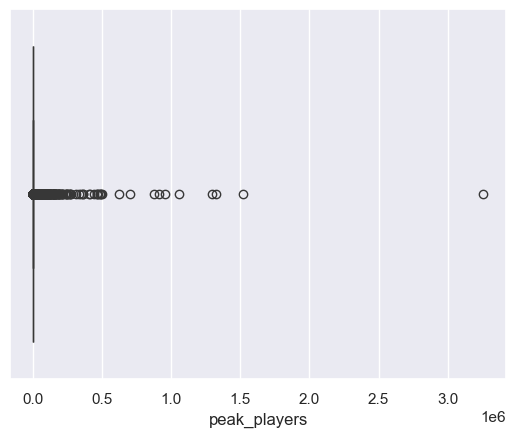

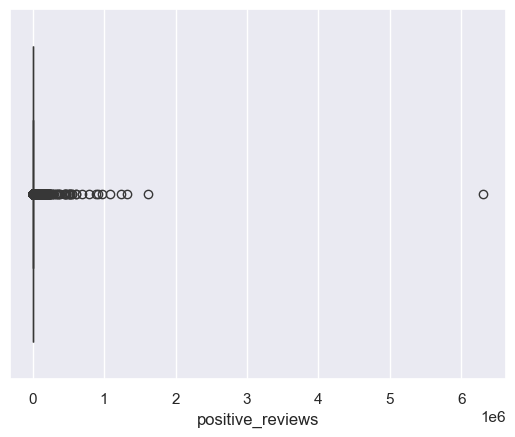

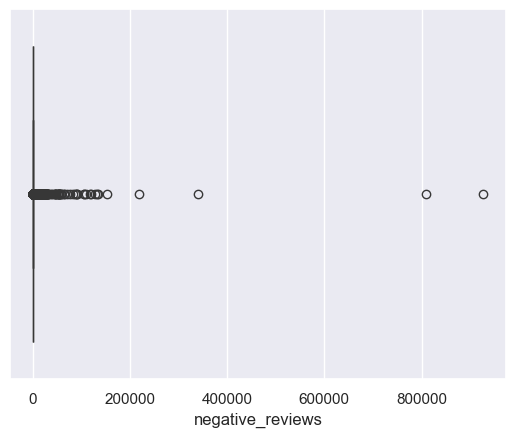

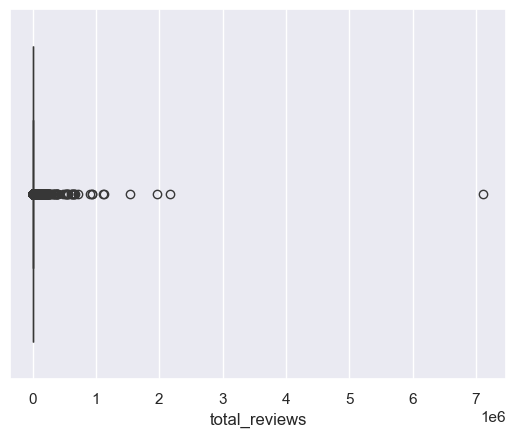

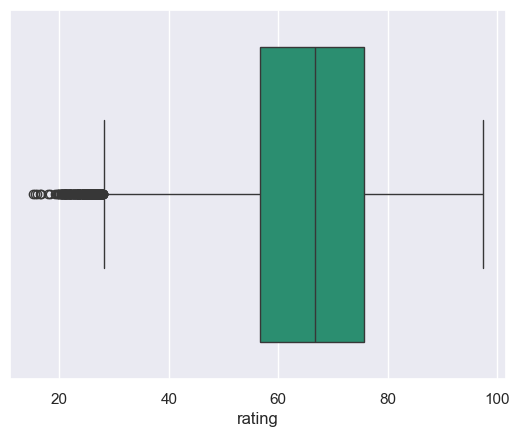

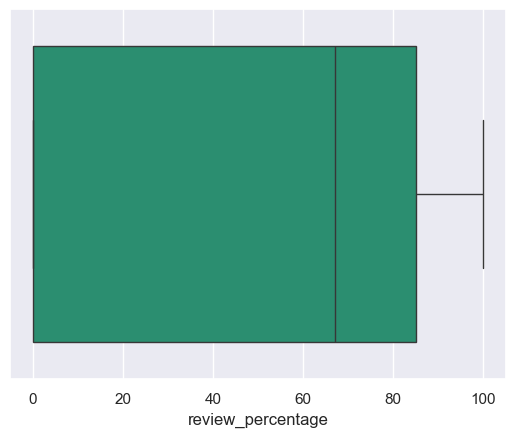

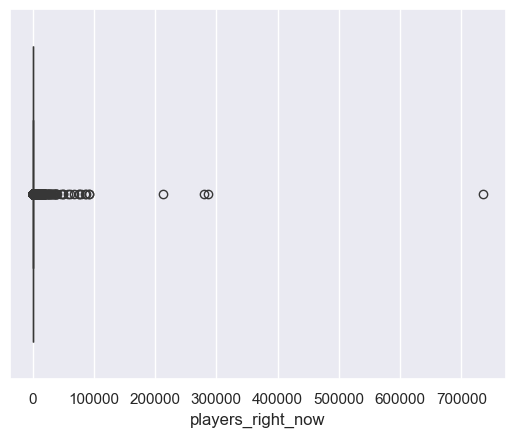

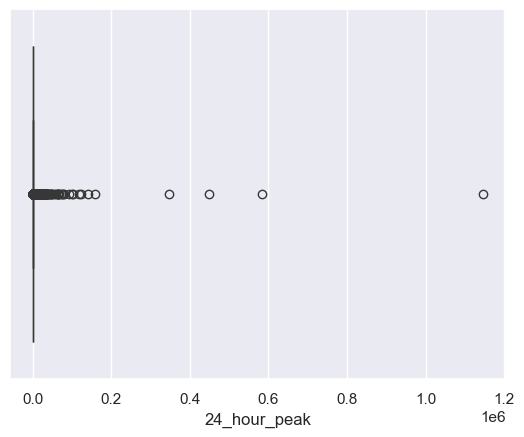

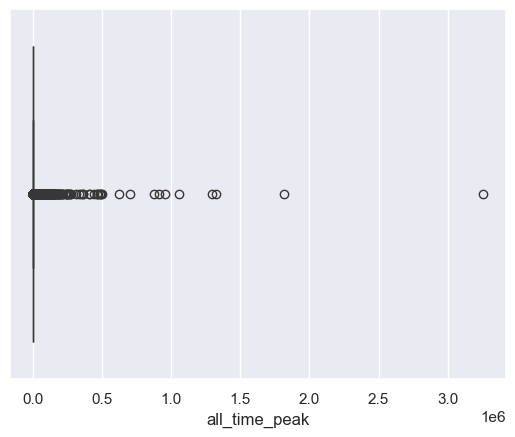

In [221]:
outliners(df)

## 5. Data Recheck

In [222]:
df.head(10)

,game,release,peak_players,positive_reviews,negative_reviews,total_reviews,rating,primary_genre,store_genres,publisher,developer,detected_technologies,review_percentage,players_right_now,24_hour_peak,all_time_peak,all_time_peak_date
0,Pizza Tower,2023-01-26,4529,19807,227,20034,96.39,Action,Action,Tour De Pizza,Tour De Pizza,Engine.GameMaker,98.0,3101,3606,4529,2023-03-25
1,Resident Evil 4,2023-03-24,168191,61752,1616,63368,95.75,Action,Action,CAPCOM Co. Ltd.,CAPCOM Co. Ltd.,Engine.RE_Engine,97.0,46289,47164,168191,2023-03-25
2,The Murder of Sonic the Hedgehog,2023-03-31,15543,12643,213,12856,95.54,Casual,Casual,SEGA,SEGA,Engine.Unity,98.0,618,776,15543,2023-03-31
3,Pineapple on pizza,2023-03-28,1415,11717,209,11926,95.39,Indie,Casual,Majorariatto,Majorariatto,Engine.Unity,98.0,101,101,1415,2023-03-28
4,Hi-Fi RUSH,2023-01-25,6132,14152,324,14476,95.09,Action,Action,Bethesda Softworks,Tango Gameworks,Engine.Unreal,97.0,630,664,6132,2023-01-29
5,东北之夏,2023-01-09,8672,8891,165,9056,95.08,RPG,Free to Play,庄不纯工作室,庄不纯工作室,Engine.Unity,98.0,62,75,8672,2023-01-10
6,Crab Champions,2023-04-01,8564,5129,81,5210,94.76,Action,Action,Noisestorm Limited,Noisestorm Limited,Engine.Unreal,98.0,4142,6419,8564,2023-04-08
7,Papa's Freezeria Deluxe,2023-03-31,1227,1832,20,1852,93.84,Strategy,Action,Flipline Studios,Flipline Studios,Engine.Adobe_AIR,99.0,661,838,1227,2023-04-02
8,A Space for the Unbound,2023-01-19,338,1917,27,1944,93.64,Adventure,Adventure,Toge Productions,Mojiken,Engine.Unity,98.0,63,63,338,2023-01-20
9,Handshakes,2023-01-13,195,1166,10,1176,93.30,Free to Play,Casual,Pet Pumpkin,Pet Pumpkin,Engine.Unity,99.0,8,15,195,2023-01-21


Text(0, 0.5, 'Values')

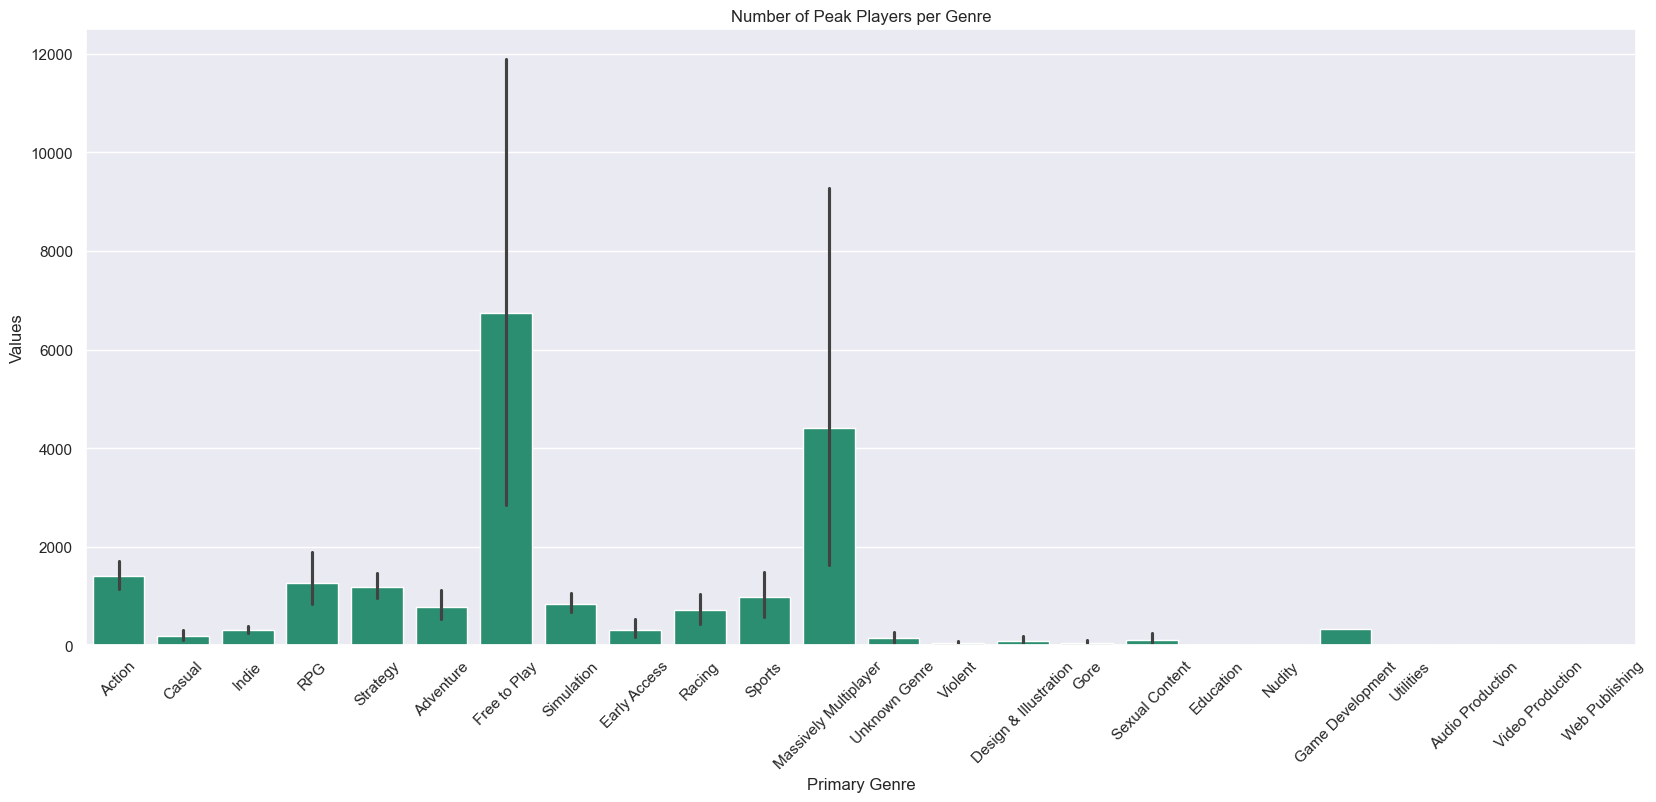

In [223]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.xticks(rotation=45)
sns.barplot(df, x = 'primary_genre', y = 'all_time_peak')
ax.set_title('Number of Peak Players per Genre')
ax.set_xlabel('Primary Genre')
ax.set_ylabel('Values')

## 6. Feature Enginering

In [236]:
df.head()

,game,release,peak_players,positive_reviews,negative_reviews,total_reviews,rating,primary_genre,store_genres,publisher,developer,detected_technologies,review_percentage,players_right_now,24_hour_peak,all_time_peak,all_time_peak_date,time_to_peak,drop_in_players,players_difference,release_year,release_month,release_day,all_time_peak_year,all_time_peak_month,all_time_peak_day,mean_review_dev,mean_review_tech
0,Pizza Tower,2023-01-26,4529,19807,1.13,20034,96.39,Action,Action,Tour De Pizza,Tour De Pizza,Engine.GameMaker,98.0,3101,3606,4529,2023-03-25,58,505,923,2023,1,26,2023,3,25,98.00,51.97
1,Resident Evil 4,2023-03-24,168191,61752,2.55,63368,95.75,Action,Action,CAPCOM Co. Ltd.,CAPCOM Co. Ltd.,Engine.RE_Engine,97.0,46289,47164,168191,2023-03-25,1,875,121027,2023,3,24,2023,3,25,81.57,78.35
2,The Murder of Sonic the Hedgehog,2023-03-31,15543,12643,1.66,12856,95.54,Casual,Casual,SEGA,SEGA,Engine.Unity,98.0,618,776,15543,2023-03-31,0,158,14767,2023,3,31,2023,3,31,79.56,52.71
3,Pineapple on pizza,2023-03-28,1415,11717,1.75,11926,95.39,Indie,Casual,Majorariatto,Majorariatto,Engine.Unity,98.0,101,101,1415,2023-03-28,0,0,1314,2023,3,28,2023,3,28,92.33,52.71
4,Hi-Fi RUSH,2023-01-25,6132,14152,2.24,14476,95.09,Action,Action,Bethesda Softworks,Tango Gameworks,Engine.Unreal,97.0,630,664,6132,2023-01-29,4,34,5468,2023,1,25,2023,1,29,82.80,48.75


In [225]:
# New Feature time_to_peak
df['time_to_peak'] = (df['all_time_peak_date'] - df['release']).astype('str')
df['time_to_peak'] = df['time_to_peak'].apply(clean_genre, args= ' ')

In [226]:
# New Feature drop_in_players
df['drop_in_players'] = df['24_hour_peak'] - df['players_right_now']

In [227]:
# New Feature players_difference
df['players_difference'] = df['all_time_peak'] - df['24_hour_peak']

In [228]:
# New Feature Year, Month, Day of Release Date
df['release_year'] = df['release'].dt.year
df['release_month'] = df['release'].dt.month
df['release_day'] = df['release'].dt.day

In [229]:
# New Feature Year, Month, Day of All_time_peak Date
df['all_time_peak_year'] = df['all_time_peak_date'].dt.year
df['all_time_peak_month'] = df['all_time_peak_date'].dt.month
df['all_time_peak_day'] = df['all_time_peak_date'].dt.day

In [230]:
# New Feature perc_players_reviewed
df['negative_reviews'] = ((df['negative_reviews'] / df['total_reviews']) *100).round(2)

In [231]:
# New Feature with mean review for each Developer
df['mean_review_dev'] = df.groupby('developer')['review_percentage'].transform('mean').round(2)

In [235]:
# New Feature with mean review for each Tech
df['mean_review_tech'] = df.groupby('detected_technologies')['review_percentage'].transform('mean').round(2)

In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66741 entries, 0 to 67569
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   game                   66741 non-null  object        
 1   release                66741 non-null  datetime64[ns]
 2   peak_players           66741 non-null  int64         
 3   positive_reviews       66741 non-null  int64         
 4   negative_reviews       66741 non-null  float64       
 5   total_reviews          66741 non-null  int64         
 6   rating                 66741 non-null  float64       
 7   primary_genre          66741 non-null  object        
 8   store_genres           66741 non-null  object        
 9   publisher              66741 non-null  object        
 10  developer              66741 non-null  object        
 11  detected_technologies  66741 non-null  object        
 12  review_percentage      66741 non-null  float64       
 13  player

perc dla danego dev
perc dla danej tech
